In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import rc

import jax.numpy as jnp
import jax.random as jrandom
import jax.scipy
from jax import value_and_grad


### Constants and utils

In [2]:
# Variance of observations
obs_noise = 1

rand_key = jrandom.PRNGKey(1)

### Kink-shaped function

In [3]:
def foo(x):
    if x < 4:
        return x + 1
    else:
        return -4 * x + 21

In [4]:
def get_samples(num_samples, obs_noise=1):
    x_samples = np.zeros((num_samples + 1,))
    x_samples[0] = np.random.uniform(-10, -8)
    y_samples = np.zeros((num_samples,))
    
    for i in range(num_samples):
        y = np.random.normal(foo(x_samples[i]), obs_noise)
        y_samples[i] = y
        x_samples[i + 1] = y

    return x_samples[:-1], y_samples

Plotting

In [5]:
xs = np.linspace(-10,8, 200)

In [6]:
ys = [foo(x) for x in xs]
samples_x, samples_y = get_samples(100, 1)

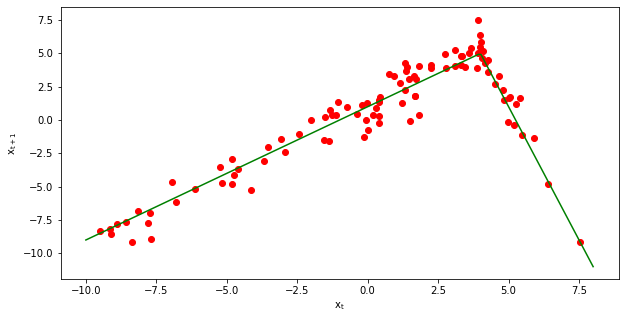

In [7]:
plt.figure(figsize=(10,5))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.xlabel('$x_{t}$')
plt.ylabel('$x_{t + 1}$')
plt.plot(xs, ys, color='green')
plt.scatter(samples_x, samples_y, color='red')
plt.show()

### Linear regression

In [8]:
basis_dims = 2

In [9]:
def basis_functions(X):
    phi = np.zeros((basis_dims + 1, X.shape[0]))
    for i in range(0, basis_dims + 1):
        phi[i] = np.power(X, i)
    return phi

def loss(theta, phi, obs_noise, y):
#     log_likelihood = jax.scipy.stats.norm.logpdf(y, phi.T @ theta, obs_noise)
#     return (-1) * jnp.mean(log_likelihood)

    return jnp.mean(jnp.power(y - (phi.T @ theta), 2))

def gradient_descent(X, y, lr=jnp.array([0.0001, 0.0001, 0.0001]), obs_noise=1, num_steps=25):
    theta = np.random.normal(size=(basis_dims + 1,))
    phi = basis_functions(X)
    print(f"START - theta = {theta}")
    for i in range(num_steps):
        loss_val, grad_loss = value_and_grad(loss, 0)(theta, phi, obs_noise, y)
        theta = theta - np.multiply(lr, grad_loss)
        print(f"STEP: {i}, loss = {loss_val}, theta: {theta}")
    return theta

In [10]:
X, y = np.array([x for x in range(100)]), np.array([x ** 2 for x in range(100)])

gradient_descent(X, y)

START - theta = [0.56674765 1.53199976 0.30726231]
STEP: 0, loss = 8844504.0, theta: [1.00638832e+00 3.44679396e+01 2.62699818e+03]
STEP: 1, loss = 134536780316672.0, theta: [-1.72382772e+03 -1.28675235e+05 -1.02422050e+07]
STEP: 2, loss = 2.046599911326064e+21, theta: [6.72560717e+06 5.01875037e+08 3.99474953e+10]
STEP: 3, loss = 3.1133289543792438e+28, theta: [-2.62317609e+10 -1.95745494e+12 -1.55806481e+14]
STEP: 4, loss = 4.736057127147498e+35, theta: [1.02311271e+14 7.63462486e+15 6.07689268e+17]
STEP: 5, loss = inf, theta: [-3.99042778e+17 -2.97771920e+19 -2.37015921e+21]
STEP: 6, loss = inf, theta: [1.55637924e+21 1.16139422e+23 9.24429032e+24]
STEP: 7, loss = inf, theta: [-6.07031856e+24 -4.52976552e+26 -3.60553363e+28]
STEP: 8, loss = inf, theta: [2.36759530e+28 1.76673650e+30 1.40625984e+32]
STEP: 9, loss = inf, theta: [-9.23428989e+31 -6.89076958e+33            -inf]
STEP: 10, loss = nan, theta: [nan nan nan]
STEP: 11, loss = nan, theta: [nan nan nan]
STEP: 12, loss = nan, t

array([nan, nan, nan])